# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing values according to the findings above.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# assign all rows that new_page and treatment don't line up to x dataframes
x = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index

In [9]:
# assign the new dataframes with dropping x rows
df2 = df.drop(x)

In [10]:
# Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(subset = ['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(['user_id'],inplace=True)

In [15]:
# check if the rows are removed
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroa. 

What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_conv = df2.converted.mean()
print('probability of all an individual converting :{percent:.2%}'.format(percent=p_conv))

probability of all an individual converting :11.96%


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_cont_conv = df2.query('group == "control"').converted.mean()
print('probability of an individual control group who converted to new page:{percent:.2%}'.format(percent=p_cont_conv))

probability of an individual control group who converted to new page:12.04%


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_tre_conv = df2.query('group == "treatment"').converted.mean()
print('probability of an individual treatment group who converted to new page:{percent:.2%}'.format(percent=p_tre_conv))

probability of an individual treatment group who converted to new page:11.88%


d. What is the probability that an individual received the new page?

In [19]:
p_n_pag = df2.landing_page.value_counts()['new_page'] / df2.landing_page.count()
print('probability of an individual received the new page :{percent:.2%}'.format(percent=p_n_pag))

probability of an individual received the new page :50.01%


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

To answer this question, I applied Sampling Distribution of difference between Means to get know if these results could lead to convincing decision

In [20]:
# calculate the mean differences between treatment and control group
mean_diff = p_tre_conv - p_cont_conv
mean_diff

-0.0015782389853555567

The sampling distribution of the difference between the means shows that the mean of an individual treatment group who converted to new page is higher than the mean of an individual control group who converted. 

For 10,000 iterations, bootstrap sample the sample data, and compute the difference in the average for control and experiment group who converted to new page. Building a 99% confidence interval using data sampling distribution.

In [21]:
# 10000 iterations for 5000 of data sampling
diffs = []
for _ in range(10000):
    b_samp = df2.sample(5000, replace=True)
    p_cont_conv = b_samp.query('group == "control"').converted.mean()
    p_tre_conv = b_samp.query('group == "treatment"').converted.mean()
    diffs.append(p_tre_conv - p_cont_conv)
    
# Compute the qth percentile of the data along the specified axis    
np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)    

(-0.019981142744098904, 0.016769522935911888)

As mentioned above from sampling distribution of difference, the conversion rates for the treatment group is more than the conversion rate for control, which not supported by the difference in means was generated by bootstrapping. The confidence interval shows that data distributed with negative and positive values.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

###### Hypothesis

$H_{0}$ : $p_{new}$ <= $p_{old}$

$H_{1}$ : $p_{new}$ >  $p_{old}$

###### In other words,

$H_{0}$ : $p_{new}$ - $p_{old}$ <= 0

$H_{1}$ : $p_{new}$ -  $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2.converted.mean()
print('convert rate for page new under the null: {percent:.2%}'.format(percent=p_new))

convert rate for page new under the null: 11.96%


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
print('convert rate for page old under the null: {percent:.2%}'.format(percent=p_old))

convert rate for page old under the null: 11.96%


c. What is $n_{new}$?

In [24]:
n_new = df2.query('landing_page == "new_page"').shape[0]
print('the number of page new: {}'.format(n_new))

the number of page new: 145310


d. What is $n_{old}$?

In [25]:
n_old = df2.query('landing_page == "old_page"').shape[0]
print('the number of page new: {}'.format(n_old))

the number of page new: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
s_n_new = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
s_n_old = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
s_n_new_m = s_n_new.mean()
s_n_old_m = s_n_old.mean()

In [29]:
s_n_new_m - s_n_old_m

-0.000614728682999735

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    s_n_new = np.random.binomial(1,p_new,n_new)
    s_n_old = np.random.binomial(1,p_old,n_old)
    s_n_new_m = s_n_new.mean()
    s_n_old_m = s_n_old.mean()
    p_diffs.append(s_n_new_m - s_n_old_m)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

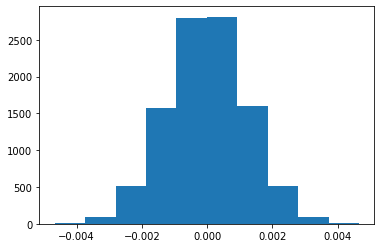

In [31]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# This is the observed statistic from ab_data.csv
mean_diff

-0.0015782389853555567

In [33]:
p_val = (p_diffs > mean_diff).mean()
print('p-value: {percent:.2%}'.format(percent=p_val))

p-value: 90.69%


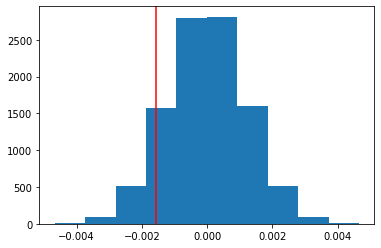

In [34]:
plt.hist(p_diffs);
plt.axvline(mean_diff,color = 'r');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

I computed p-value which measures the probability that the null hypothesis is true. The observed statistic in the dataset is the difference in means of treatment and control groups who converted to a new page. In plotting sampling distribution under the null hypothesis,  p-value fall above observed statistic. Therefore, large p-value that higher than type I error rate of 0.05, gives substantial evidence to accept the null hypothesis to be true. 
###### Holding in the old page is equal or better than to convert to the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "new_page"').shape[0]
n_new = df2.query('landing_page == "old_page"').shape[0]

n_old,convert_old,n_new,convert_new 

(145310, 17489, 145274, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],value=0,alternative='larger')
z_score, p_value

(-1.2616957421858055, 0.8964708551967226)

In [37]:
# for 95% confidence interval what is the z_score
from scipy.stats import norm

z_upper = norm.ppf(q = 0.975)
z_lower = norm.ppf(q = 0.025)
z_upper,z_lower

(1.959963984540054, -1.9599639845400545)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**At 95% confidence interval, it found that the z-score of the distribution in dataset (ab_data.csv) is less than the critical z-score (1.2616  <  1.9599). Moreover, the computed p-value is 0.8964, which is also greater than the alpha level of 0.05. Therefore,  the test fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**In this case, Logistic Regression is used to examine two categorical variables.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2[['treatment','control']] = pd.get_dummies(df2['group'])
df2.drop('treatment',axis=1,inplace=True)
df2 = df2.rename(columns={"control":"ab_page"})
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:51:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

In Part II, testing assumes that whether the old page is better or equal to the new page ( higher conversion rate).

In the regression model, $H_{0}$ assumes that there is no relationship to the converted and ab_page, while $H_{1}$ assumes that there is a relationship to the converted and ab_page.

**Both p-values either in Part II computed (0.9) or associated with ab_page (0.19) are fail to reject the null hypothesis because they are greater than significance level $α$ at 0.05.**

Above logistic regression shows that there is a dependency relationship with conversion and the page user received. However with very small p-value this relation is unlikely to be significant statistically.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering additional variables might give more insight into conversion. For instance, factors like gender, age, country or timetamp and attempt to link them under two groups. However, realizing that adding more variables may lead to misleading results. For example, making a decision based on time spent on a new page since it needs a while to be acclimated by users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
### Create the necessary dummy variables

df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
### Fit Your Linear Model And Obtain the Results
log_mod2 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US']])
results = log_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        02:54:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [44]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [45]:
1/np.exp(-0.0149)

1.0150115583846535

For each one-unit decrease in ab_page, convert is 1.015 times as likely holding everything else constant.

For each one-unit increase in UK conversion is 1.05 times more likely than CA, holding everything else constant.

For every one-unit increase in US conversion is 1.04 times likely than CA, holding all else constant.

**The p-value associated with ab_page is 0.191 which means the relationship to conversion and the explanatory variables used in the regression model is not statistically significant.**

<a id='conclusions'></a>
## Conclusions

### Project Limitations
  * Conducting the experiment in long enough run time. Considering that user behavior changes after period of time.
  
  
  * As mentioned above, choose one or more suitable metric leads to the strong decision.

### Summary



The most important findings are:

  * In A/B test, findings show that the p-value is 0.896 which is greater than type I error with α = 0.05, and the z-score is 1.2616 which is less than the critical z-score 1.9599. Therefore, the test fail to reject the null hypothesis which indicate that holding in the old page is equal or better than to convert to the new page.


  * In regression model for conversion based on which page a customer receives, there is a dependency relationship with them but with very small p-value this relation is unlikely to be significant statistically.
  
  
  * In regression model for conversion based on which country a user lives, the p-value associated with ab_page is 0.191 which means the relationship to conversion and these variables values mentioned in the last section is not statistically significant.


  * As a result, there is no evidence proved that the new page has a better conversion rate than the old page.